In [1]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline
import os

In [2]:
"""
Step1: Camera Calibration and distortion correction
"""

# prepare object points
objp = np.zeros((6 * 9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# arrays to store object points and image points from the chessboard images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# read in a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# step through each image and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # if found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# distortion correction 
def distortion_correction(img, objpoints, imgpoints):
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
    # undistort image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
    

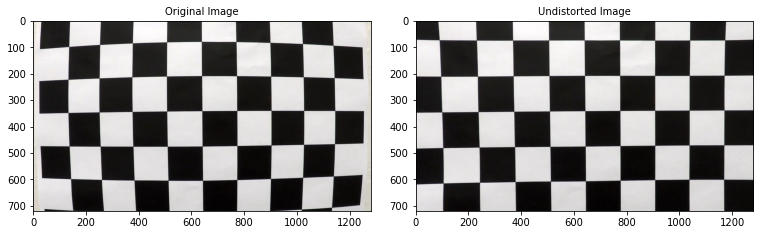

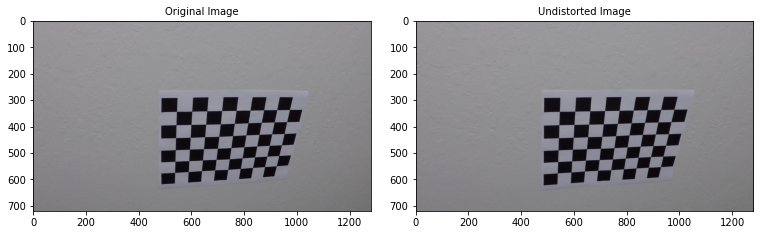

In [3]:
# visualize the undistorted image
def test_distortion_correction(img_path):
    img = cv2.imread(img_path)
    undist_img = distortion_correction(img, objpoints, imgpoints)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()
    
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
test_distortion_correction('camera_cal/calibration1.jpg') 
test_distortion_correction('camera_cal/calibration10.jpg')  

# test_distortion_correction('test_images/test1.jpg')

In [4]:
"""
Step2: Color Gradient Threshold
"""
def get_threshold(img, s_thresh=[150,255], sx_thresh=[25,100]):
    img = np.copy(img)
    # convert to HSV color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # combine two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    

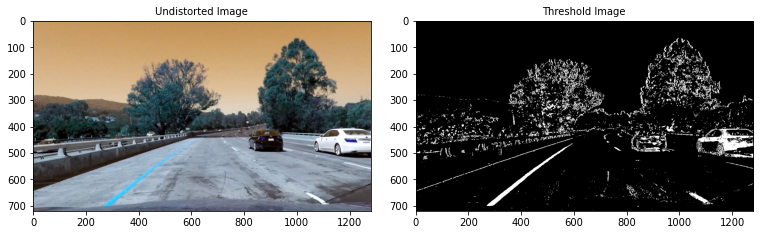

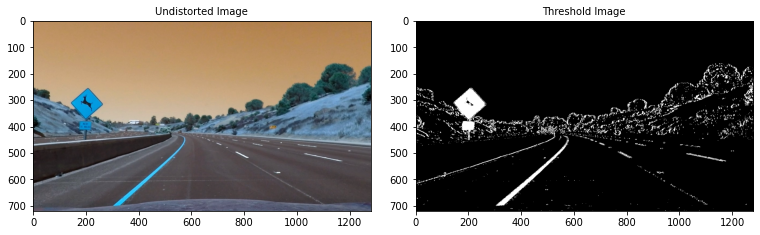

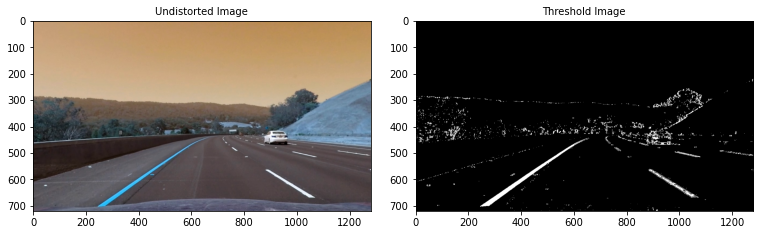

In [5]:
def test_get_threshold(img_path):
    img = cv2.imread(img_path)
    undist = distortion_correction(img, objpoints, imgpoints)
    threshold_img = get_threshold(undist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.tight_layout()    
    ax1.imshow(undist)
    ax1.set_title('Undistorted Image', fontsize=10)
    ax2.imshow(threshold_img, cmap='gray')
    ax2.set_title('Threshold Image', fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test_get_threshold('test_images/test1.jpg')    
test_get_threshold('test_images/test2.jpg')
test_get_threshold('test_images/test3.jpg')


Text(0.5, 1.0, 'Warped Image')

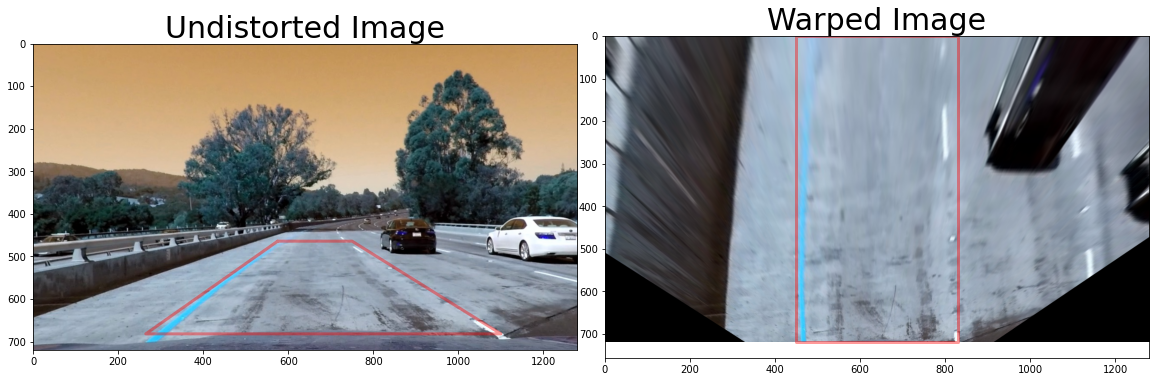

In [6]:
"""
Step3: warp the image using perspective transformation
"""

def warp(img, src, dst):
    h, w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv


img = cv2.imread('test_images/test1.jpg')
undist = distortion_correction(img, objpoints, imgpoints)

h, w = undist.shape[:2]
src = np.float32([(575,464),
                  (750,464), 
                  (265,682), 
                  (1100,682)])

dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

test_warp, M, Minv = warp(undist, src, dst)
# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(test_warp)
x = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
y = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]
ax2.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax2.set_title('Warped Image', fontsize=30)


In [7]:
"""
Step4: Finding the lanes
"""
def fit_binary_warped(binary_warped):
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 110
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)\
         & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)\
         & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig('output_images/fit_output')
    plt.show()

    return left_fit, right_fit

# Detect lane pixels and fit to find the lane boundary using look ahead filter
def fit_binary_warped_look_ahead_filter(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 110
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

In [8]:
"""
Step5: curvature calculation
"""
# Compute the curvature of lane line
def curvature(left_fit, right_fit):
    ploty = np.linspace(0, 719, num=720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    y_eval = np.max(ploty)/2
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

In [9]:
"""
Step6: distance from the center
"""
# Compute the vehicle's distance from lane center.
def distance_from_center(img, left_fit, right_fit):
    y_max = img.shape[0]
    x_max = img.shape[1]
    left_fitx = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_fitx = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    xm_per_pix = 3.7/700
    dist = x_max/2-(left_fitx+right_fitx)/2
    if dist>=0: direction = 'right'
    else: direction = 'left'
    distance = np.abs(dist)*xm_per_pix
    return distance, direction

In [10]:
"""
Drawing
"""
# Draw the detected lane boundaries back onto the original image
def drawing(undist, warped, left_fit, right_fit, Minv):
    ploty = np.linspace(0, 719, num=720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

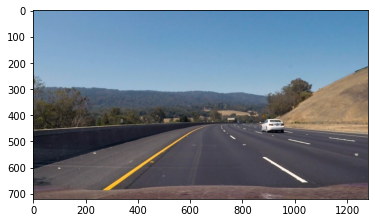

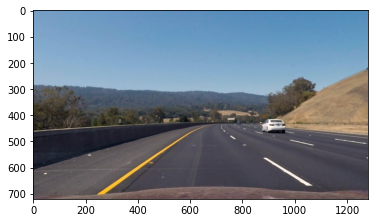

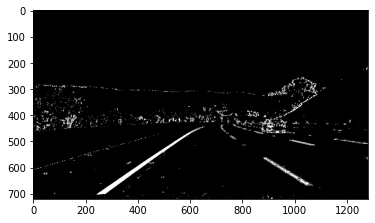

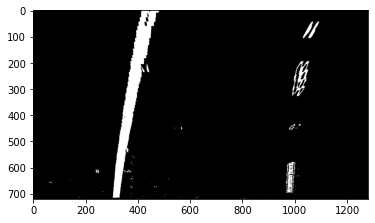

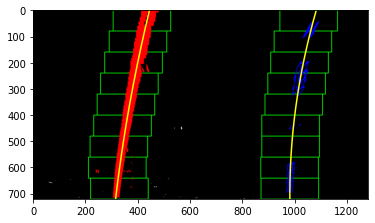

1906.766464967657 808.4045577218934


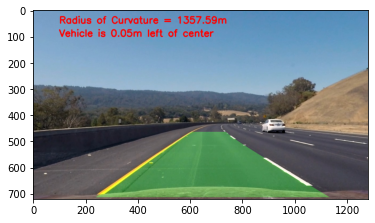

In [11]:
image = mpimg.imread('test_images/test3.jpg')
undist = distortion_correction(image, objpoints, imgpoints)
h,w = undist.shape[:2]
combined_binary = get_threshold(undist)

src = np.float32([[575,464],[710,464], [1093,714], [218,714]])
img_size = (image.shape[1], image.shape[0])
dst = np.float32([[300,0],[950,0], [950,img_size[1]], [300,img_size[1]]])
warped, M, Minv = warp(combined_binary, src, dst)
plt.imshow(image)
plt.show()
plt.imshow(undist)
plt.savefig('output_images/undist')
plt.show()
plt.imshow(combined_binary,cmap='gray')
plt.savefig('output_images/combined_binary')
plt.show()
plt.imshow(warped,cmap='gray')
plt.savefig('output_images/warped')
plt.show()
left_fit, right_fit = fit_binary_warped(warped)
left_curverad, right_curverad = curvature(left_fit, right_fit)
print(left_curverad, right_curverad)
distance, direction = distance_from_center(image, left_fit, right_fit)
result = drawing(undist, warped, left_fit, right_fit, Minv)
cv2.putText(result, 'Radius of Curvature = '+str('%.*f' % (2,(left_curverad+right_curverad)/2))+'m', (100,50),\
            cv2.FONT_HERSHEY_SIMPLEX,1.2,255,thickness=3)
cv2.putText(result, 'Vehicle is '+str('%.*f' % (2, distance))+'m '+direction+' of center', (100,100),\
            cv2.FONT_HERSHEY_SIMPLEX,1.2,255,thickness=3)
plt.imshow(result)
plt.savefig('output_images/final_result')
plt.show()


In [12]:
# Define a subclass of list which can maintain the length of the list
class SubList(list):
    def append(self, item):
        list.append(self, item)
        if len(self) > 6: 
            self[:1]=[]

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # did the line detection fail in the last n iterations?
        self.detected = False  
        # fitting coefficients list of left and right lane
        self.left_fit = SubList() 
        self.right_fit = SubList()
        # radius of curvature of the line in meter
        self.radius_of_curvature = None 
        # the record of bad lane detection
        self.bad_detection = SubList()

In [13]:
# The final pipeline used in processing the video
def process_image(image):
    undist = distortion_correction(image, objpoints, imgpoints)
    combined_binary = get_threshold(undist)
    warped, M, Minv = warp(combined_binary, src, dst)
    if lane_lines.detected == False: # blind search
        left_fit, right_fit = fit_binary_warped(warped)
        left_curverad, right_curverad = curvature(left_fit, right_fit)
        # determine if left and right curvature is similar
        if 0.1 <= (left_curverad/right_curverad) <= 10: 
            lane_lines.left_fit.append(left_fit)
            lane_lines.right_fit.append(right_fit)
            lane_lines.detected = True
            lane_lines.radius_of_curvature = (left_curverad+right_curverad)/2
            lane_lines.bad_detection.append(0)
        else:
            lane_lines.bad_detection.append(1)
    else: # look-ahead-filter
        left_fit, right_fit = fit_binary_warped_look_ahead_filter(warped, \
                                                                  lane_lines.left_fit[-1], lane_lines.right_fit[-1])
        left_curverad, right_curverad = curvature(left_fit, right_fit)
        if 0.1 <= (left_curverad/right_curverad) <= 10:
            lane_lines.left_fit.append(left_fit)
            lane_lines.right_fit.append(right_fit)
            lane_lines.radius_of_curvature = (left_curverad+right_curverad)/2
            lane_lines.bad_detection.append(0)
        else:
            lane_lines.bad_detection.append(1)
    # if last 5 detection failed, return to blind search
    if np.sum(lane_lines.bad_detection[-5:]) == 5:
        lane_lines.detected = False
    # smooth the fitting parameters over last 5 measurments    
    left_fit_mean = np.mean(lane_lines.left_fit[-5:],0)
    right_fit_mean = np.mean(lane_lines.right_fit[-5:],0)
    distance, direction = distance_from_center(image, left_fit_mean, right_fit_mean)
    result = drawing(undist, warped, left_fit_mean, right_fit_mean, Minv)
    # display the radius of curvature and vechicle postion from center in final video output
    cv2.putText(result, 'Radius of Curvature = '+str('%.*f' % (2,lane_lines.radius_of_curvature))+'m', (100,50),\
            cv2.FONT_HERSHEY_SIMPLEX,1.2,255,thickness=2)
    cv2.putText(result, 'Vehicle = '+str('%.*f' % (2, distance))+'m '+direction+' of center', (100,100),\
            cv2.FONT_HERSHEY_SIMPLEX,1.2,255,thickness=2)
    return result


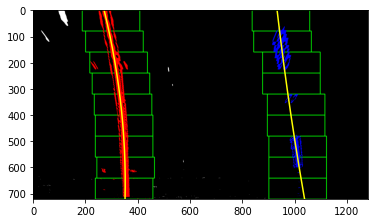

t:   0%|          | 0/250 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



t:  99%|█████████▉| 247/250 [00:52<00:00,  4.99it/s, now=None]

In [ ]:
lane_lines = Line()
# Comment and uncomment white_output and clip line for challengers video
white_output = 'project_video_output.mp4'
#white_output = 'challenge_video_output.mp4'
#white_output = 'harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(0,10)
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0,10)
#clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,10)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


In [ ]:
clip2 = VideoFileClip("project_video_output.mp4").resize(0.2)
clip2.write_gif("project_video.gif")
from IPython.display import Image
Image(url='project_video.gif')
